In [1]:
%%time
import glob, datetime, warnings, utm, mcaap, sys, random, pickle
sys.path.append('/Users/mronacgiannone/Documents/Cardinal')
import cardinal
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from obspy import *
from obspy.core import *
from scipy import signal
from pyproj import Geod; g = Geod(ellps='sphere')
from scipy.signal import hilbert, butter, filtfilt
from scipy.ndimage import uniform_filter1d

warnings.filterwarnings('ignore')

# Global variables where data are stored
summer_data_dir = '/Volumes/Extreme SSD/McAAP/Summer_2021/'

# Freq ranges (Averbuch et al. [2022])
freqmin=1; freqmax=10

CPU times: user 8.88 s, sys: 6.46 s, total: 15.3 s
Wall time: 30.3 s


---
Ancillary functions

In [3]:
def pad_to_target_time(x, T, axis=-1, mode='edge', *, noise_scale=1.0, robust=False, seed=None):
    """
    Pad/trim along `axis` to length T.

    mode:
      - 'edge'    : repeat the last sample
      - 'reflect' : mirror the tail (skip endpoint)
      - 'noisy'   : pad with PURE zero-mean noise ~ N(0, σ^2),
                    σ from the window per series (or MAD-based if robust=True)
    """
    x = np.asarray(x)
    if not np.issubdtype(x.dtype, np.floating):
        x = x.astype(np.float32)

    x_move = np.moveaxis(x, axis, -1)  # (..., N)
    N = x_move.shape[-1]

    if N == T:
        return x
    if N == 0:
        raise ValueError("Cannot pad from an empty axis.")
    if N > T:
        y = x_move[..., :T]
        return np.moveaxis(y, -1, axis)

    pad = T - N

    if mode == 'edge':
        last = x_move[..., -1:]                     # (..., 1)
        pad_block = np.repeat(last, pad, axis=-1)   # (..., pad)

    elif mode == 'reflect':
        tail = np.flip(x_move[..., :-1], axis=-1)   # (..., N-1)
        if tail.shape[-1] == 0:                     # N==1 -> fallback
            last = x_move[..., -1:]
            pad_block = np.repeat(last, pad, axis=-1)
        else:
            reps = int(np.ceil(pad / tail.shape[-1]))
            pad_block = np.concatenate([tail] * reps, axis=-1)[..., :pad]

    elif mode == 'noisy':
        # PURE noise centered at 0
        if robust:
            med = np.median(x_move, axis=-1, keepdims=True)
            mad = np.median(np.abs(x_move - med), axis=-1, keepdims=True)
            sigma = 1.4826 * mad
        else:
            sigma = x_move.std(axis=-1, keepdims=True)
        sigma = noise_scale * sigma

        rng = np.random.default_rng(seed)
        pad_block = rng.normal(0.0, 1.0, size=x_move[..., :pad].shape).astype(x_move.dtype) * sigma

    else:
        raise ValueError("mode must be 'edge', 'reflect', or 'noisy'")

    y = np.concatenate([x_move, pad_block], axis=-1)
    return np.moveaxis(y, -1, axis)

def center_by_env_peak(data):
    """
    Center via the peak of the analytic-signal envelope (no smoothing).
    - data: 1D numpy array
    """
    x = np.asarray(data, dtype=np.float32)
    x = x/np.max(np.abs(x))
    analytic_signal = signal.hilbert(x)
    env = np.abs(analytic_signal)
    i = int(np.argmax(env))
    i_hat = float(i)
    k_shift = (len(x) / 2.0) - i_hat   # no clamp
    return k_shift

def shift_extrapolate_time(x, shift, axis=-1, mode='edge', *, noise_scale=1.0, robust=False, seed=None):
    """
    Shift along `axis` by `shift` samples with interpolation.

    Modes
    -----
    'edge'        : clamp to first/last sample
    'reflect'     : symmetric reflection
    'extrapolate' : linear extrapolation from first/last two samples
    'noisy'       : OUT-OF-BOUNDS -> pure zero-mean noise ~ N(0, σ^2),
                    σ from the window per series (or MAD-based if robust=True).
                    IN-BOUNDS -> regular linear interpolation.
    """
    x = np.asarray(x)
    if not np.issubdtype(x.dtype, np.floating):
        x = x.astype(np.float32)

    x_move = np.moveaxis(x, axis, -1)  # (..., T)
    T = x_move.shape[-1]
    s = float(shift)

    t = np.arange(T, dtype=np.float64)  # output indices
    u = t - s                           # where to sample from input

    flat = x_move.reshape(-1, T)        # (N, T)
    N = flat.shape[0]

    if T == 0:
        return x.copy()

    # Common interpolation for interior (used by edge/reflect/noisy)
    def interp_at(u_vals):
        u_clamped = np.clip(u_vals, 0.0, T - 1.0)
        u0 = np.floor(u_clamped).astype(np.int64)
        u1 = np.minimum(u0 + 1, T - 1)
        alpha = (u_clamped - u0).astype(flat.dtype)
        return (1.0 - alpha) * flat[:, u0] + alpha * flat[:, u1]

    if mode == 'edge':
        y_flat = interp_at(np.clip(u, 0.0, T - 1.0))

    elif mode == 'reflect':
        if T > 1:
            period = 2.0 * (T - 1.0)
            u_ref = np.mod(u, period)
            u_ref = np.where(u_ref <= (T - 1.0), u_ref, period - u_ref)
        else:
            u_ref = np.zeros_like(u)
        y_flat = interp_at(u_ref)

    elif mode == 'extrapolate':
        y_flat = np.empty((N, T), dtype=flat.dtype)
        if T == 1:
            y_flat[:] = flat[:, [0]]
        else:
            u_b = u[None, :]
            s0 = (flat[:, 1] - flat[:, 0])[:, None]
            sN = (flat[:, -1] - flat[:, -2])[:, None]

            idxL = np.where(u < 0.0)[0]
            idxR = np.where(u > (T - 1.0))[0]
            idxI = np.where((u >= 0.0) & (u <= (T - 1.0)))[0]

            if idxL.size:
                y_flat[:, idxL] = flat[:, 0:1] + u_b[:, idxL] * s0
            if idxR.size:
                y_flat[:, idxR] = flat[:, -1:] + (u_b[:, idxR] - (T - 1.0)) * sN
            if idxI.size:
                uI = u[idxI]
                u0I = np.clip(np.floor(uI).astype(np.int64), 0, T - 2)
                u1I = u0I + 1
                alphaI = (uI - u0I).astype(flat.dtype)
                y_flat[:, idxI] = (1.0 - alphaI) * flat[:, u0I] + alphaI * flat[:, u1I]

    elif mode == 'noisy':
        # Interior = interpolation; tails = pure zero-mean noise
        y_flat = interp_at(u)  # start with interior everywhere, overwrite tails

        rng = np.random.default_rng(seed)
        if robust:
            med = np.median(flat, axis=1, keepdims=True)
            mad = np.median(np.abs(flat - med), axis=1, keepdims=True)
            sigma = 1.4826 * mad
        else:
            sigma = flat.std(axis=1, keepdims=True)

        sigma *= noise_scale

        idxL = np.where(u < 0.0)[0]
        idxR = np.where(u > (T - 1.0))[0]

        if idxL.size:
            noiseL = rng.normal(0.0, 1.0, size=(N, idxL.size)).astype(flat.dtype) * sigma
            y_flat[:, idxL] = noiseL  # baseline = 0
        if idxR.size:
            noiseR = rng.normal(0.0, 1.0, size=(N, idxR.size)).astype(flat.dtype) * sigma
            y_flat[:, idxR] = noiseR  # baseline = 0
    else:
        raise ValueError("mode must be 'edge', 'reflect', 'extrapolate', or 'noisy'")

    y = y_flat.reshape(x_move.shape)
    return np.moveaxis(y, -1, axis)

def _butter_band(fs, f_lo, f_hi, order=4):
    nyq = 0.5 * fs
    lo = max(f_lo / nyq, 1e-6)
    hi = min(f_hi / nyq, 1.0 - 1e-6)
    if not (0 < lo < hi < 1):
        raise ValueError("Band edges out of range.")
    return butter(order, [lo, hi], btype='band')

def measure_band_snr_db_waveform(x, fs, f_lo=5.0, f_hi=10.0, order=4, eps=1e-12):
    x = np.asarray(x)
    b, a = _butter_band(fs, f_lo, f_hi, order)
    xb = filtfilt(b, a, x, axis=-1)         # in-band "signal"
    P_sig = np.mean(xb**2, axis=-1)
    P_tot = np.mean(x**2,  axis=-1)
    P_off = np.maximum(P_tot - P_sig, 0.0) + eps
    return 10.0 * np.log10((P_sig + eps) / P_off)

def add_lowband_noise_to_hit_snr_db(x, fs, target_snr_db, axis=-1, order=4, guard_hz=0.3, relax=0.8, seed=None):
    """
    Add *off-band* noise (≈1–5 Hz) so SNR_dB = 10*log10(P_5-10 / (P_total - P_5-10))
    matches target_snr_db. Leaves 5–10 Hz morphology untouched.
    """
    x = np.asarray(x)
    xT = np.moveaxis(x, axis, -1)  # (..., T)

    # Current in-band (5–10) and off-band (1–5) powers
    b_hi, a_hi = _butter_band(fs, 5.0, 10.0, order)
    b_lo, a_lo = _butter_band(fs, 1.0,  5.0,  order)
    x_hi = filtfilt(b_hi, a_hi, xT, axis=-1); P_hi = np.mean(x_hi**2, axis=-1, keepdims=True)
    x_lo = filtfilt(b_lo, a_lo, xT, axis=-1); P_lo = np.mean(x_lo**2, axis=-1, keepdims=True)

    # Desired off-band power to hit target SNR
    target_lin = 10.0 ** (target_snr_db / 10.0)
    P_lo_target = P_hi / np.maximum(target_lin, 1e-8)
    delta = P_lo_target - P_lo
    # If already noisy enough (delta <= 0), return unchanged
    if np.all(delta <= 0):
        return x

    # Build low-band noise template in 1 – (5 - guard)
    f_hi_noise = max(5.0 - guard_hz, 1.5)
    bN, aN = _butter_band(fs, 1.0, f_hi_noise, order)
    rng = np.random.default_rng() if seed is None else np.random.default_rng(seed)
    w = rng.normal(0.0, 1.0, size=xT.shape).astype(xT.dtype)
    n = filtfilt(bN, aN, w, axis=-1)

    # Compute off-band power of the template to scale it
    n_lo = filtfilt(b_lo, a_lo, n, axis=-1)
    c = np.mean(n_lo**2, axis=-1, keepdims=True) + 1e-12

    sigma = np.sqrt(np.maximum(delta, 0.0) / c) * float(relax)  # relax < 1 softens
    x_noisy = xT + sigma * n
    return np.moveaxis(x_noisy, -1, axis)

---
Construct MCB Dataset

In [4]:
%%time
# Directory path to MCB trimmed data
file_pattern = summer_data_dir+'MCB_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
MCB_data = []; row_labels_MCB = []
for MCB_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(MCB_data_filepath); st = st.resample(40).merge() # need to resample to keep all input feature vectors the same length
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter 5 - 10 Hz center cue and store 1 - 10 Hz
    st_center = st.copy() # 5 - 10 Hz center cue
    st_center.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_center.filter('bandpass', freqmin=5, freqmax=10)
    except:
        st_center = st_center.split()
        st_center.filter('bandpass', freqmin=5, freqmax=10)
        st_center.merge()
    # Filter 1 - 10 Hz store
    st_save = st.copy()
    st_save.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_save.filter('bandpass', freqmin=1, freqmax=10)
    except:
        st_save = st_save.split()
        st_save.filter('bandpass', freqmin=1, freqmax=10)
        st_save.merge()
    julian_day = MCB_data_filepath[-9:-6] # as string
    for tr in st_center:
        # Load onset times for each station
        signal_onset_time_filepath = summer_data_dir+'MCB_Detections/Signal_Times_CWT/'+tr.stats.station+'_'+tr.stats.channel+'/'+julian_day+'.npy'
        with open(signal_onset_time_filepath, 'rb') as f: # loading signal onset times
            MCB_times_tmp = np.load(f)[0]
        #-----------------------------------------------------------------------------------------------------------------------#
        # Extract data from each trace using 30 second windows (+/- 15 seconds from signal onset time)
        t = np.arange(0, tr.stats.delta*tr.stats.npts, tr.stats.delta)
        # match same station in st_save
        tr_s_list = st_save.select(station=tr.stats.station)
        if len(tr_s_list) == 0: 
            continue
        tr_s = tr_s_list[0]
        # Window +/-15 s around beam onset (same cut for both)
        st_tmp = Stream().append(tr)
        st_tmp_s = Stream().append(tr_s)
        for sig_idx in range(len(MCB_times_tmp)):    
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number
            row_labels_MCB_tmp = f"{str(tr.stats.starttime).split('T')[0]}_{tr.stats.station}_{sig_idx+1}"
            row_labels_MCB.append(row_labels_MCB_tmp)
            #-----------------------------------------------------------------------------------------------------------------------#
            # Retrieve time windowed data
            t_data, data = cardinal.data_time_window(t, st_tmp, t_start=MCB_times_tmp[sig_idx]-15, t_end=MCB_times_tmp[sig_idx]+15)
            _, data_s = cardinal.data_time_window(t, st_tmp_s, t_start=MCB_times_tmp[sig_idx]-15, t_end=MCB_times_tmp[sig_idx]+15)
            #-----------------------------------------------------------------------------------------------------------------------# 
            # Enforce target length (time axis is axis=1) - just in case
            fs = float(tr.stats.sampling_rate)
            target_length = int(30 * fs) # e.g., 40 s @ fs 
            data = pad_to_target_time(data, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            data_s = pad_to_target_time(data_s, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            #-----------------------------------------------------------------------------------------------------------------------#
            # Compute shift from 5–10 Hz window, apply to 1–10 Hz window
            x = data[0, :].astype(np.float32)  # (T,)
            k_shift = center_by_env_peak(x) # time shift to center
            x_s = data_s[0, :].astype(np.float32)
            x_s_centered = shift_extrapolate_time(x_s[None,:], k_shift, axis=1, mode='noisy', noise_scale=0.1)[0]   
            #-----------------------------------------------------------------------------------------------------------------------#
            # Lower direct SNR in 1-5 Hz band to match strat cross-spectral SNR
            rng = np.random.default_rng(123)
            # Use your strat stats (dB):
            mu, sigma = -3.50, 4.47 # mu is median
            p10, p90  = -10, 1.10
            target = float(np.clip(rng.normal(mu, sigma), p10, p90))
            # After you create x_s_centered (your 1–10 Hz window):
            x_bal = add_lowband_noise_to_hit_snr_db(x_s_centered, fs, target_snr_db=target, order=4, guard_hz=0, relax=0.5, seed=None)            
            MCB_data.append(x_bal)
MCB_data = np.array(MCB_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_MCB = {label: MCB_data[idx] for idx, label in enumerate(row_labels_MCB)}
print(MCB_data.shape)

(11906, 1200)
CPU times: user 2min 56s, sys: 4.35 s, total: 3min
Wall time: 3min 4s


<IPython.core.display.Javascript object>


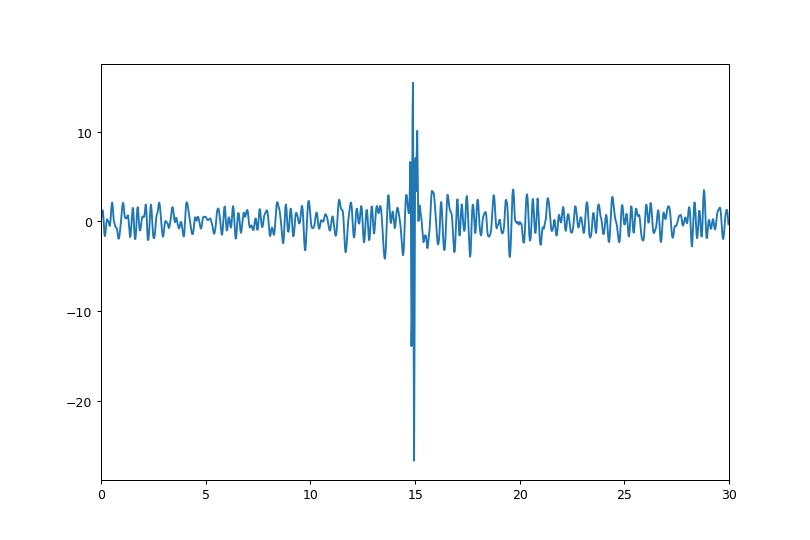

(0.0, 30.0)

In [5]:
%matplotlib notebook
# Generate a random integer between 0 and total number of signals at MCA
rand_int = random.randint(0, MCB_data.shape[0])
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting randomly indexed signal
fig = plt.figure(figsize=(9,6))
data_tmp = mcaap.extract_signals_from_dict(row_dict_MCB, rand_int)[1]
plt.plot(t_data, data_tmp)
plt.xlim([0,30])

---
Construct WCT Dataset

In [6]:
%%time
# Directory path to WCT trimmed data
file_pattern = summer_data_dir+'WCT_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
WCT_data = []; row_labels_WCT = []; strato_snr_db = []
for WCT_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(WCT_data_filepath)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter
    st_filt = st.copy()
    st_filt.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_filt.filter('bandpass', freqmin=1, freqmax=10)
    except:
        st_filt = st_filt.split()
        st_filt.filter('bandpass', freqmin=1, freqmax=10)
        st_filt.merge()
    julian_day = WCT_data_filepath[-9:-6] # as string
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load onset times from WCT beam (will use same time for each station)
    signal_onset_time_filepath = summer_data_dir+'WCT_Detections/Beamform_Signal_Times_CWT/WCT_Beam/'+julian_day+'.npy'
    with open(signal_onset_time_filepath, 'rb') as f: # loading signal onset times
        WCT_times_tmp = np.load(f)[0]
    #-----------------------------------------------------------------------------------------------------------------------#
    # Fixing issues after manually checking signals
    if str(st[0].stats.starttime).split('T')[0] == '2021-06-09':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-06-10':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-06-11':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-07-06':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-09-07':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-09-13':
        continue        
    #-----------------------------------------------------------------------------------------------------------------------#
    for sig_idx in range(len(WCT_times_tmp)):
        # Fixing signal timing issues
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-16':
            if sig_idx+1 == 2: 
                WCT_times_tmp[sig_idx] -= 5
            if sig_idx+1 == 13: 
                WCT_times_tmp[sig_idx] -= 3
            if sig_idx+1 == 14: 
                WCT_times_tmp[sig_idx] -= 3
            if sig_idx+1 == 15: 
                WCT_times_tmp[sig_idx] -= 5
            if sig_idx+1 == 16: 
                WCT_times_tmp[sig_idx] -= 4
            if sig_idx+1 == 18: 
                WCT_times_tmp[sig_idx] -= 4
            if sig_idx+1 == 19: 
                WCT_times_tmp[sig_idx] -= 3
            if sig_idx+1 == 23: 
                WCT_times_tmp[sig_idx] -= 3
            if sig_idx+1 == 24: 
                WCT_times_tmp[sig_idx] -= 5
        #-----------------------------------------------------------------------------------------------------------------------#    
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-19':
            if sig_idx+1 == 19: 
                WCT_times_tmp[sig_idx] -= 3.5
        #-----------------------------------------------------------------------------------------------------------------------#    
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-22':
            if (sig_idx+1==2) or (sig_idx+1==3) or (sig_idx+1==4): 
                continue
            if (sig_idx+1 == 17) or (sig_idx+1 == 18) or (sig_idx+1 == 19) or (sig_idx+1 == 20) or (sig_idx+1 == 21) or (sig_idx+1 == 29) or (sig_idx+1 == 31) or (sig_idx+1 == 32) or(sig_idx+1 == 33) or (sig_idx+1 == 34) or (sig_idx+1 == 35) or (sig_idx+1 == 40) or (sig_idx+1 == 45):
                continue
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-23':
            if (sig_idx+1==1) or (sig_idx+1==2) or (sig_idx+1==3) or (sig_idx+1==4) or (sig_idx+1==5) or (sig_idx+1==6) or (sig_idx+1==7) or (sig_idx+1==8) or (sig_idx+1==9) or (sig_idx+1==26) or (sig_idx+1==30) or (sig_idx+1==31) or (sig_idx+1==34) or (sig_idx+1==37) or (sig_idx+1==38) or (sig_idx+1==45): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-24':
            if (sig_idx+1==19) or (sig_idx+1==20) or (sig_idx+1==27): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-25':
            if (sig_idx+1==34): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-28':
            if (sig_idx+1==8)or(sig_idx+1==9)or(sig_idx+1==10)or(sig_idx+1==11)or(sig_idx+1==12)or(sig_idx+1==13)or(sig_idx+1==14)or(sig_idx+1==15)or(sig_idx+1==17)or(sig_idx+1==44)or(sig_idx+1==46)or(sig_idx+1==48)or(sig_idx+1==49)or(sig_idx+1==50)or(sig_idx+1==51): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-29':
            if (sig_idx+1==26) or (sig_idx+1==28): 
                continue
            if sig_idx+1==27:
                WCT_times_tmp[sig_idx] -= 6
            if (sig_idx+1==39)or(sig_idx+1==40)or(sig_idx+1==41)or(sig_idx+1==42)or(sig_idx+1==43)or(sig_idx+1==44)or(sig_idx+1==45)or(sig_idx+1==46)or(sig_idx+1==47): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-01':
            if sig_idx+1==2: 
                WCT_times_tmp[sig_idx] -= 5
            if sig_idx+1==3: 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-07':
            if (sig_idx+1==11) or (sig_idx+1==14): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-12':
            if (sig_idx+1==43): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-13':
            if sig_idx+1==2:
                WCT_times_tmp[sig_idx] -= 5
            if (sig_idx+1==5)or(sig_idx+1==6)or(sig_idx+1==7)or(sig_idx+1==8)or(sig_idx+1==9)or(sig_idx+1==10)or(sig_idx+1==11)or(sig_idx+1==13)or(sig_idx+1==14)or(sig_idx+1==22)or(sig_idx+1==23): 
                WCT_times_tmp[sig_idx] -= 4
            if sig_idx+1==12: 
                WCT_times_tmp[sig_idx] -= 2
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-14':
            if (sig_idx+1==1) or (sig_idx+1==3) or (sig_idx+1==4) or (sig_idx+1==5) or (sig_idx+1==10) or (sig_idx+1==15):
                continue     
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-15':
            if (sig_idx+1==34) or (sig_idx+1==35):
                continue       
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-23':
            if (sig_idx+1==5) or (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==11) or (sig_idx+1==15):
                continue
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-27':
            if (sig_idx+1==2):
                continue                 
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-29':
            if sig_idx+1==2: 
                WCT_times_tmp[sig_idx] -= 5
            if (sig_idx+1==4)or(sig_idx+1==5)or(sig_idx+1==6)or(sig_idx+1==7)or(sig_idx+1==8): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-03':
            if sig_idx+1==28: 
                continue                
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-04':
            if sig_idx+1==2: 
                WCT_times_tmp[sig_idx] -= 2.5
            if (sig_idx+1==26) or (sig_idx+1==27) or (sig_idx+1==30) or (sig_idx+1==31) or (sig_idx+1==33) or (sig_idx+1==34): 
                continue                
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-05':
            if (sig_idx+1==18)or(sig_idx+1==19)or(sig_idx+1==20)or(sig_idx+1==29)or(sig_idx+1==30)or(sig_idx+1==31)or(sig_idx+1==41)or(sig_idx+1==44)or(sig_idx+1==46)or(sig_idx+1==48)or(sig_idx+1==49)or(sig_idx+1==50): 
                WCT_times_tmp[sig_idx] -= 4
            if (sig_idx+1==25): 
                continue                
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-09':
            if (sig_idx+1==5)or(sig_idx+1==6): 
                WCT_times_tmp[sig_idx] -= 6
            if (sig_idx+1==18) or (sig_idx+1==26): 
                continue                
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-10':
            if (sig_idx+1==17) or (sig_idx+1==19) or (sig_idx+1==20) or (sig_idx+1==21): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-12':
            if (sig_idx+1==13): 
                WCT_times_tmp[sig_idx] -= 6
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-14':
            if (sig_idx+1==16) or (sig_idx+1==17): 
                continue                
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-16':
            if (sig_idx+1==8):
                WCT_times_tmp[sig_idx] -= 2.5
            if (sig_idx+1==38)or(sig_idx+1==39)or(sig_idx+1==40)or(sig_idx+1==41)or(sig_idx+1==42)or(sig_idx+1==43)or(sig_idx+1==44)or(sig_idx+1==45)or(sig_idx+1==46)or(sig_idx+1==47)or(sig_idx+1==48)or(sig_idx+1==49)or(sig_idx+1==50)or(sig_idx+1==51): 
                WCT_times_tmp[sig_idx] -= 5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-20':
            if (sig_idx+1==1) or (sig_idx+1==3) or (sig_idx+1==5) or (sig_idx+1==12) or (sig_idx+1==13) or (sig_idx+1==14) or (sig_idx+1==30) or (sig_idx+1==34) or (sig_idx+1==35) or (sig_idx+1==45) or (sig_idx+1==46): 
                continue                     
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-23':
            if (sig_idx+1==12)or(sig_idx+1==35):
                WCT_times_tmp[sig_idx] -= 2.5
            if (sig_idx+1==13)or(sig_idx+1==14)or(sig_idx+1==15)or(sig_idx+1==16)or(sig_idx+1==17)or(sig_idx+1==18)or(sig_idx+1==19)or(sig_idx+1==20)or(sig_idx+1==21)or(sig_idx+1==22)or(sig_idx+1==34): 
                WCT_times_tmp[sig_idx] -= 5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-24':
            if (sig_idx+1==41) or (sig_idx+1==42) or (sig_idx+1==43) or (sig_idx+1==44): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-26':
            if (sig_idx+1==51) or (sig_idx+1==52): 
                WCT_times_tmp[sig_idx] -= 6
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-30':
            if sig_idx+1 != 1: 
                WCT_times_tmp[sig_idx] -= 3.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-31':
            if (sig_idx+1==9): 
                continue        
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-09-03':
            if (sig_idx+1==14) or (sig_idx+1==15) or (sig_idx+1==16) or (sig_idx+1==17): 
                continue    
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-09-08':
            if (sig_idx+1==4): 
                continue 
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-09-09':
            if (sig_idx+1==1) or (sig_idx+1==3) or (sig_idx+1==11): 
                continue 
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-09-10':
            if (sig_idx+1==3) or (sig_idx+1==4) or (sig_idx+1==5) or (sig_idx+1==6) or (sig_idx+1==7) or (sig_idx+1==24) or (sig_idx+1==25) or (sig_idx+1==44): 
                continue 
        #-----------------------------------------------------------------------------------------------------------------------#
        # Loop through each trace in stream
        for tr in st_filt:
            # Extract data from each trace using 30 second windows (+/- 15 seconds from beam onset time)
            t = np.arange(0, tr.stats.delta*tr.stats.npts, tr.stats.delta)
            st_tmp = Stream().append(tr)
            if tr.stats.station == 'WCT01':
                continue # move on from WCT01 - too many impulsive noise segments
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-14':
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1 == 22) or (sig_idx+1==23): 
                        continue
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1 == 1) or (sig_idx+1 == 9): 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-15':
                if tr.stats.station == 'WCT07':
                    if sig_idx+1 == 9: 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-17':
                if tr.stats.station == 'WCT07':
                    if sig_idx+1 == 2: 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-18':
                if tr.stats.station == 'WCT02':
                    if sig_idx+1 == 43: 
                        continue
                if tr.stats.station == 'WCT04':
                    if sig_idx+1 == 40: 
                        continue
                if tr.stats.station == 'WCT05':
                    if sig_idx+1 == 41: 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-19':
                if tr.stats.station == 'WCT02':
                    if sig_idx+1 == 25: 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-22':
                if tr.stats.station == 'WCT02': 
                    if (sig_idx+1==11) or (sig_idx+1==16) or (sig_idx+1==30): 
                        continue
                if tr.stats.station == 'WCT04': 
                    if (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==16) or (sig_idx+1==34) or (sig_idx+1==46): 
                        continue
                if tr.stats.station == 'WCT05': 
                    if (sig_idx+1==7) or (sig_idx+1==32): 
                        continue
                if tr.stats.station == 'WCT07': 
                    if (sig_idx+1==10) or (sig_idx+1==12) or (sig_idx+1==15) or (sig_idx+1==19) or (sig_idx+1==28) or (sig_idx+1==30): 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-23':
                if tr.stats.station == 'WCT02': 
                    if (sig_idx+1==25) or (sig_idx+1==36) or (sig_idx+1==39) or (sig_idx+1==40) or (sig_idx+1==41): 
                        continue
                if tr.stats.station == 'WCT03': 
                    if (sig_idx+1==1) or (sig_idx+1==41) or (sig_idx+1==43) or (sig_idx+1==44): 
                        continue
                if tr.stats.station == 'WCT04': 
                    if (sig_idx+1==11) or (sig_idx+1==13) or (sig_idx+1==32) or (sig_idx+1==43): 
                        continue
                if tr.stats.station == 'WCT05': 
                    if (sig_idx+1==11) or (sig_idx+1==14) or (sig_idx+1==16) or (sig_idx+1==17) or (sig_idx+1==39) or (sig_idx+1==43): 
                        continue       
                if tr.stats.station == 'WCT07': 
                    if (sig_idx+1==15) or (sig_idx+1==33) or (sig_idx+1==41): 
                        continue                         
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-24':
                if tr.stats.station == 'WCT02': 
                    if (sig_idx+1==23) or (sig_idx+1==29) or (sig_idx+1==30) or (sig_idx+1==37) or (sig_idx+1==51) or (sig_idx+1==52): 
                        continue
                if tr.stats.station == 'WCT03': 
                    if (sig_idx+1==3) or (sig_idx+1==5) or (sig_idx+1==21): 
                        continue                        
                if tr.stats.station == 'WCT04': 
                    if (sig_idx+1==1) or (sig_idx+1==5) or (sig_idx+1==18) or (sig_idx+1==21): 
                        continue
                if tr.stats.station == 'WCT05': 
                    if (sig_idx+1==1) or (sig_idx+1==11) or (sig_idx+1==12) or (sig_idx+1==13) or (sig_idx+1==18) or (sig_idx+1==21) or (sig_idx+1==23) or (sig_idx+1==50): 
                        continue
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==15) or (sig_idx+1==18) or (sig_idx+1==22) or (sig_idx+1==23) or (sig_idx+1==28) or (sig_idx+1==29) or (sig_idx+1==45) or (sig_idx+1==51): 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-25':
                if tr.stats.station == 'WCT02': 
                    if (sig_idx+1==3) or (sig_idx+1==5) or (sig_idx+1==11) or (sig_idx+1==33) or (sig_idx+1==37): 
                        continue
                if tr.stats.station == 'WCT03': 
                    if (sig_idx+1==29): 
                        continue
                if tr.stats.station == 'WCT04': 
                    if (sig_idx+1==27) or (sig_idx+1==29): 
                        continue
                if tr.stats.station == 'WCT05': 
                    if (sig_idx+1==3) or (sig_idx+1==14) or (sig_idx+1==29): 
                        continue
                if tr.stats.station == 'WCT07': 
                    if (sig_idx+1==2) or (sig_idx+1==3) or (sig_idx+1==8) or (sig_idx+1==11) or (sig_idx+1==12): 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-29':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==2) or (sig_idx+1==28) or (sig_idx+1==34) or (sig_idx+1==50):
                        continue
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==31):
                        continue
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==6) or (sig_idx+1==8) or (sig_idx+1==33):
                        continue
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==12) or (sig_idx+1==14):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-01':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==4):
                        continue
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==9) or (sig_idx+1==21):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-07':
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==51):
                        continue
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==28) or (sig_idx+1==31) or (sig_idx+1==32) or (sig_idx+1==33):
                        continue
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==15) or (sig_idx+1==16):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-08':
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==52):
                        continue
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==35) or (sig_idx+1==45) or (sig_idx+1==46):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-09':
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==12):
                        continue      
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-13':
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==6):
                        continue 
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==2) or (sig_idx+1==42):
                        continue                        
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==2):
                        continue   
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-14':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==10) or (sig_idx+1==13) or (sig_idx+1==26) or (sig_idx+1==27) or (sig_idx+1==28) or (sig_idx+1==30):
                        continue
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==12):
                        continue
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==14) or (sig_idx+1==18) or (sig_idx+1==24) or (sig_idx+1==25):
                        continue      
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==14) or (sig_idx+1==17) or (sig_idx+1==25) or (sig_idx+1==28) or (sig_idx+1==29) or (sig_idx+1==30):
                        continue     
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==14) or (sig_idx+1==17) or (sig_idx+1==21) or (sig_idx+1==29) or (sig_idx+1==30):
                        continue     
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-15':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==17) or (sig_idx+1==22) or (sig_idx+1==46):
                        continue  
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==2) or (sig_idx+1==9) or (sig_idx+1==20) or (sig_idx+1==22) or (sig_idx+1==23) or (sig_idx+1==39) or (sig_idx+1==40) or (sig_idx+1==41):
                        continue        
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==9) or (sig_idx+1==18) or (sig_idx+1==20) or (sig_idx+1==25):
                        continue  
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==9) or (sig_idx+1==18) or (sig_idx+1==19) or (sig_idx+1==20) or (sig_idx+1==21) or (sig_idx+1==23) or (sig_idx+1==25) or (sig_idx+1==36) or (sig_idx+1==37) or (sig_idx+1==46):
                        continue  
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-19':
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==39) or (sig_idx+1==40) or (sig_idx+1==41):
                        continue     
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==16) or (sig_idx+1==17) or (sig_idx+1==20) or (sig_idx+1==29) or (sig_idx+1==30) or (sig_idx+1==31) or (sig_idx+1==32) or (sig_idx+1==39) or (sig_idx+1==40) or (sig_idx+1==41) or (sig_idx+1==42) or (sig_idx+1==46) or (sig_idx+1==47):
                        continue    
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==30) or (sig_idx+1==31):
                        continue      
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-20':
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==25) or (sig_idx+1==26) or (sig_idx+1==27):
                        continue     
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==2) or (sig_idx+1==46):
                        continue     
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==2) or (sig_idx+1==12) or (sig_idx+1==13) or (sig_idx+1==30) or (sig_idx+1==45) or (sig_idx+1==46):
                        continue    
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==2) or (sig_idx+1==12):
                        continue      
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-22':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==40):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-23':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==7) or (sig_idx+1==10) or (sig_idx+1==12) or (sig_idx+1==16):
                        continue
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==18) or (sig_idx+1==25):
                        continue                        
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==7) or (sig_idx+1==8) or (sig_idx+1==13) or (sig_idx+1==26):
                        continue
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==3) or (sig_idx+1==13) or (sig_idx+1==14) or (sig_idx+1==35) or (sig_idx+1==37):
                        continue                        
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==3) or (sig_idx+1==6) or (sig_idx+1==7) or (sig_idx+1==12) or (sig_idx+1==18) or (sig_idx+1==19) or (sig_idx+1==26):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-28':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==23):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-29':
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==55):
                        continue                    
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==27):
                        continue         
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-02':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==13) or (sig_idx+1==28) or (sig_idx+1==31) or (sig_idx+1==36) or (sig_idx+1==37) or (sig_idx+1==42) or (sig_idx+1==48):
                        continue      
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==44):
                        continue                             
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==36):
                        continue                           
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==1) or (sig_idx+1==19) or (sig_idx+1==20) or (sig_idx+1==36) or (sig_idx+1==42) or (sig_idx+1==44):
                        continue                        
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==1) or (sig_idx+1==2) or (sig_idx+1==6) or (sig_idx+1==14) or (sig_idx+1==15) or (sig_idx+1==16) or (sig_idx+1==41) or (sig_idx+1==48):
                        continue               
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-03':
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==19) or (sig_idx+1==36) or (sig_idx+1==37) or (sig_idx+1==38) or (sig_idx+1==52):
                        continue                   
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==12) or (sig_idx+1==36) or (sig_idx+1==37) or (sig_idx+1==38) or (sig_idx+1==39) or (sig_idx+1==52):
                        continue                        
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-05':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==13) or (sig_idx+1==18) or (sig_idx+1==30) or (sig_idx+1==31):
                        continue
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==24):
                        continue                        
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==1) or (sig_idx+1==4) or (sig_idx+1==5) or (sig_idx+1==31) or (sig_idx+1==41) or (sig_idx+1==44):
                        continue       
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==29) or (sig_idx+1==31) or (sig_idx+1==39) or (sig_idx+1==47) or (sig_idx+1==50):
                        continue                             
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==3) or (sig_idx+1==4) or (sig_idx+1==18) or (sig_idx+1==22) or (sig_idx+1==23) or (sig_idx+1==30) or (sig_idx+1==31) or (sig_idx+1==37) or (sig_idx+1==47) or (sig_idx+1==48):
                        continue                           
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-06':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==6):
                        continue     
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==41) or (sig_idx+1==43):
                        continue                         
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==28) or (sig_idx+1==36):
                        continue                           
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==4) or (sig_idx+1==16) or (sig_idx+1==28) or (sig_idx+1==30) or (sig_idx+1==36):
                        continue        
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-09':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==3) or (sig_idx+1==9) or (sig_idx+1==12) or (sig_idx+1==20) or (sig_idx+1==24):
                        continue     
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==20):
                        continue                           
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==8) or (sig_idx+1==17) or (sig_idx+1==19) or (sig_idx+1==20) or (sig_idx+1==24) or (sig_idx+1==25):
                        continue  
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==12) or (sig_idx+1==17) or (sig_idx+1==19):
                        continue         
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==12) or (sig_idx+1==17):
                        continue                            
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-10':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==3) or (sig_idx+1==9) or (sig_idx+1==11) or (sig_idx+1==12) or (sig_idx+1==16):
                        continue
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==3) or (sig_idx+1==22):
                        continue                        
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==3) or (sig_idx+1==4) or (sig_idx+1==6) or (sig_idx+1==15) or (sig_idx+1==23):
                        continue                        
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==2) or (sig_idx+1==7) or (sig_idx+1==8) or (sig_idx+1==10) or (sig_idx+1==18):
                        continue                          
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==1) or (sig_idx+1==7) or (sig_idx+1==8) or (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==12) or (sig_idx+1==13) or (sig_idx+1==15) or (sig_idx+1==18) or (sig_idx+1==22) or (sig_idx+1==23):
                        continue    
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-11':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==2) or (sig_idx+1==14) or (sig_idx+1==21):
                        continue              
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==3) or (sig_idx+1==7) or (sig_idx+1==14) or (sig_idx+1==17) or (sig_idx+1==20) or (sig_idx+1==21):
                        continue   
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==4):
                        continue                
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==1) or (sig_idx+1==4) or (sig_idx+1==12) or (sig_idx+1==16):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-12':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==17) or (sig_idx+1==18):
                        continue                    
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==16) or (sig_idx+1==18) or (sig_idx+1==19):
                        continue                              
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==19):
                        continue                   
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-14':
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==13) or (sig_idx+1==14) or (sig_idx+1==20) or (sig_idx+1==25) or (sig_idx+1==26):
                        continue     
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==6) or (sig_idx+1==26):
                        continue                            
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-20':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==3) or (sig_idx+1==4) or (sig_idx+1==7) or (sig_idx+1==11) or (sig_idx+1==17) or (sig_idx+1==18) or (sig_idx+1==19) or (sig_idx+1==27) or (sig_idx+1==28) or (sig_idx+1==32) or (sig_idx+1==33) or (sig_idx+1==36) or (sig_idx+1==37):
                        continue
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==28):
                        continue                        
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==2) or (sig_idx+1==4) or (sig_idx+1==6) or (sig_idx+1==8) or (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==15) or (sig_idx+1==20) or (sig_idx+1==27) or (sig_idx+1==28):
                        continue
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==36):
                        continue    
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==7) or (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==24) or (sig_idx+1==33) or (sig_idx+1==36) or (sig_idx+1==39) or (sig_idx+1==41):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-23':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==12) or (sig_idx+1==20) or (sig_idx+1==43):
                        continue  
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==16):
                        continue  
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==16) or (sig_idx+1==20) or (sig_idx+1==37) or (sig_idx+1==44) or (sig_idx+1==49):
                        continue  
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==20) or (sig_idx+1==27) or (sig_idx+1==28) or (sig_idx+1==29):
                        continue    
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==10) or (sig_idx+1==11) or (sig_idx+1==19) or (sig_idx+1==20) or (sig_idx+1==46):
                        continue     
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-24':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==3) or (sig_idx+1==14) or (sig_idx+1==20) or (sig_idx+1==21) or (sig_idx+1==22) or (sig_idx+1==23) or (sig_idx+1==33) or (sig_idx+1==35) or (sig_idx+1==46):
                        continue 
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==46):
                        continue                         
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==6) or (sig_idx+1==10) or (sig_idx+1==15) or (sig_idx+1==16) or (sig_idx+1==19) or (sig_idx+1==33) or (sig_idx+1==34) or (sig_idx+1==46):
                        continue 
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==15) or (sig_idx+1==16) or (sig_idx+1==20) or (sig_idx+1==32) or (sig_idx+1==34) or (sig_idx+1==44):
                        continue   
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==12) or (sig_idx+1==15) or (sig_idx+1==17) or (sig_idx+1==19) or (sig_idx+1==23) or (sig_idx+1==24) or (sig_idx+1==28) or (sig_idx+1==33) or (sig_idx+1==34) or (sig_idx+1==35) or (sig_idx+1==36) or (sig_idx+1==48):
                        continue                         
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-25':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==38) or (sig_idx+1==51):
                        continue                 
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==33) or (sig_idx+1==35):
                        continue 
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==37):
                        continue                         
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-26':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==49) or (sig_idx+1==52):
                        continue     
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==49):
                        continue     
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==13) or (sig_idx+1==16) or (sig_idx+1==50) or (sig_idx+1==51):
                        continue                             
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==7) or (sig_idx+1==13):
                        continue  
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==15) or (sig_idx+1==16):
                        continue    
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-27':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==19):
                        continue  
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==14) or (sig_idx+1==19) or (sig_idx+1==43):
                        continue      
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==9) or (sig_idx+1==13) or (sig_idx+1==43) or (sig_idx+1==46) or (sig_idx+1==48):
                        continue                             
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==29) or (sig_idx+1==32) or (sig_idx+1==35) or (sig_idx+1==43) or (sig_idx+1==44) or (sig_idx+1==46) or (sig_idx+1==47) or (sig_idx+1==50):
                        continue  
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-31':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==8) or (sig_idx+1==11) or (sig_idx+1==41) or (sig_idx+1==42):
                        continue      
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==39):
                        continue                            
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==4) or (sig_idx+1==8) or (sig_idx+1==39):
                        continue                          
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==8) or (sig_idx+1==43):
                        continue  
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==4) or (sig_idx+1==5) or (sig_idx+1==41) or (sig_idx+1==42) or (sig_idx+1==45) or (sig_idx+1==46) or (sig_idx+1==47):
                        continue 
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-09-01':
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==44):
                        continue  
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-09-02':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==6) or (sig_idx+1==7) or (sig_idx+1==18) or (sig_idx+1==20) or (sig_idx+1==21) or (sig_idx+1==44) or (sig_idx+1==48) or (sig_idx+1==49):
                        continue                  
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==2) or (sig_idx+1==6) or (sig_idx+1==8) or (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==14) or (sig_idx+1==16) or (sig_idx+1==17) or (sig_idx+1==18) or (sig_idx+1==19) or (sig_idx+1==22) or (sig_idx+1==26) or (sig_idx+1==30) or (sig_idx+1==31) or (sig_idx+1==32) or (sig_idx+1==33) or (sig_idx+1==35) or (sig_idx+1==45) or (sig_idx+1==47):
                        continue          
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==7) or (sig_idx+1==8) or (sig_idx+1==14) or (sig_idx+1==18) or (sig_idx+1==21) or (sig_idx+1==26) or (sig_idx+1==31) or (sig_idx+1==35) or (sig_idx+1==44):
                        continue                         
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==3) or (sig_idx+1==5) or (sig_idx+1==7) or (sig_idx+1==8) or (sig_idx+1==11) or (sig_idx+1==16) or (sig_idx+1==18) or (sig_idx+1==19) or (sig_idx+1==20) or (sig_idx+1==21) or (sig_idx+1==22) or (sig_idx+1==26) or (sig_idx+1==28) or (sig_idx+1==33) or (sig_idx+1==35) or (sig_idx+1==37) or (sig_idx+1==49):
                        continue     
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-09-03':         
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==4) or (sig_idx+1==10) or (sig_idx+1==11) or (sig_idx+1==19):
                        continue  
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==12):
                        continue    
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==1) or (sig_idx+1==9) or (sig_idx+1==11) or (sig_idx+1==12) or (sig_idx+1==13) or (sig_idx+1==18) or (sig_idx+1==19) or (sig_idx+1==20) or (sig_idx+1==25):
                        continue      
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==12) or (sig_idx+1==13) or (sig_idx+1==18) or (sig_idx+1==19) or (sig_idx+1==20):
                        continue   
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==7) or (sig_idx+1==8) or (sig_idx+1==13) or (sig_idx+1==18) or (sig_idx+1==25):
                        continue  
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-09-08':         
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==1):
                        continue                          
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==2):
                        continue   
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-09-09':       
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==6) or (sig_idx+1==7) or (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==16) or (sig_idx+1==19) or (sig_idx+1==24) or (sig_idx+1==35):
                        continue     
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==8) or (sig_idx+1==12) or (sig_idx+1==18) or (sig_idx+1==19) or (sig_idx+1==21) or (sig_idx+1==26) or (sig_idx+1==35) or (sig_idx+1==51):
                        continue  
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==5) or (sig_idx+1==6) or (sig_idx+1==10) or (sig_idx+1==12) or (sig_idx+1==14) or (sig_idx+1==26) or (sig_idx+1==40):
                        continue                   
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==3) or (sig_idx+1==4) or (sig_idx+1==10) or (sig_idx+1==12) or (sig_idx+1==14) or (sig_idx+1==15) or (sig_idx+1==16) or (sig_idx+1==20) or (sig_idx+1==25) or (sig_idx+1==26) or (sig_idx+1==40) or (sig_idx+1==51) or (sig_idx+1==52):
                        continue   
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-09-10':       
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==19) or (sig_idx+1==23) or (sig_idx+1==40) or (sig_idx+1==42) or (sig_idx+1==45) or (sig_idx+1==46):
                        continue 
                if tr.stats.station == 'WCT03':
                    if (sig_idx+1==14) or (sig_idx+1==20) or (sig_idx+1==22):
                        continue 
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==2) or (sig_idx+1==8) or (sig_idx+1==17) or (sig_idx+1==20) or (sig_idx+1==21) or (sig_idx+1==22) or (sig_idx+1==45) or (sig_idx+1==46):
                        continue 
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==16) or (sig_idx+1==17) or (sig_idx+1==19) or (sig_idx+1==31) or (sig_idx+1==42):
                        continue 
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==1) or (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==16) or (sig_idx+1==18) or (sig_idx+1==23) or (sig_idx+1==26) or (sig_idx+1==51) or (sig_idx+1==52):
                        continue 
            #-----------------------------------------------------------------------------------------------------------------------#
            # Slightly changing the centering to capture more of the coda
            t_data, data = cardinal.data_time_window(t, st_tmp, t_start=WCT_times_tmp[sig_idx]-12.5, t_end=WCT_times_tmp[sig_idx]+17.5)
            #-----------------------------------------------------------------------------------------------------------------------#
            # Enforce target length (time axis is axis=1) - just in case
            fs = float(tr.stats.sampling_rate)
            target_length = int(30 * fs) # e.g., 40 s @ fs 
            data = pad_to_target_time(data, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            WCT_data.append(data[0,:])
            #-----------------------------------------------------------------------------------------------------------------------#
            # Measure SNR
            snr_db = measure_band_snr_db_waveform(data[0,:], fs, f_lo=5.0, f_hi=10.0)
            strato_snr_db.append(float(snr_db))            
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number
            row_labels_WCT.append(str(tr.stats.starttime).split('T')[0] + '_'+tr.stats.station+'_'+str(sig_idx+1))
WCT_data = np.array(WCT_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_WCT = {label: WCT_data[idx] for idx, label in enumerate(row_labels_WCT)}
print(WCT_data.shape)
print("Strato SNR dB: median={:.2f}, mean={:.2f}, std={:.2f}, p10={:.2f}, p90={:.2f}".format(
        np.median(strato_snr_db), np.mean(strato_snr_db), np.std(strato_snr_db),
        np.percentile(strato_snr_db, 10), np.percentile(strato_snr_db, 90)))

(11535, 1200)
Strato SNR dB: median=-3.50, mean=-4.06, std=4.47, p10=-10.00, p90=1.10
CPU times: user 1min 33s, sys: 2.59 s, total: 1min 36s
Wall time: 1min 37s


<IPython.core.display.Javascript object>


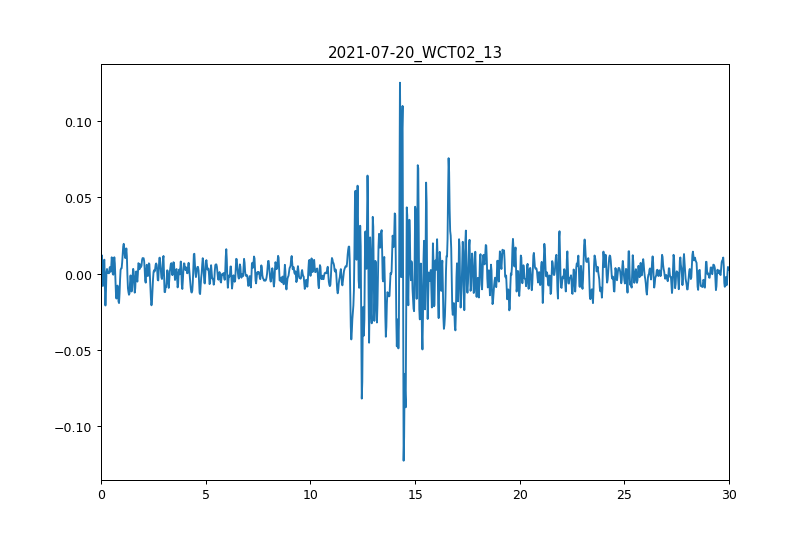

Text(0.5, 1.0, '2021-07-20_WCT02_13')

In [7]:
%matplotlib notebook
# Generate a random integer between 0 and total number of signals at EOCR
rand_int = random.randint(0, WCT_data.shape[0])
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting randomly indexed signal
fig = plt.figure(figsize=(9,6))
data_label, data_tmp = mcaap.extract_signals_from_dict(row_dict_WCT, rand_int)
plt.plot(t_data, data_tmp)
plt.xlim([0,30]); plt.title(data_label)

<IPython.core.display.Javascript object>


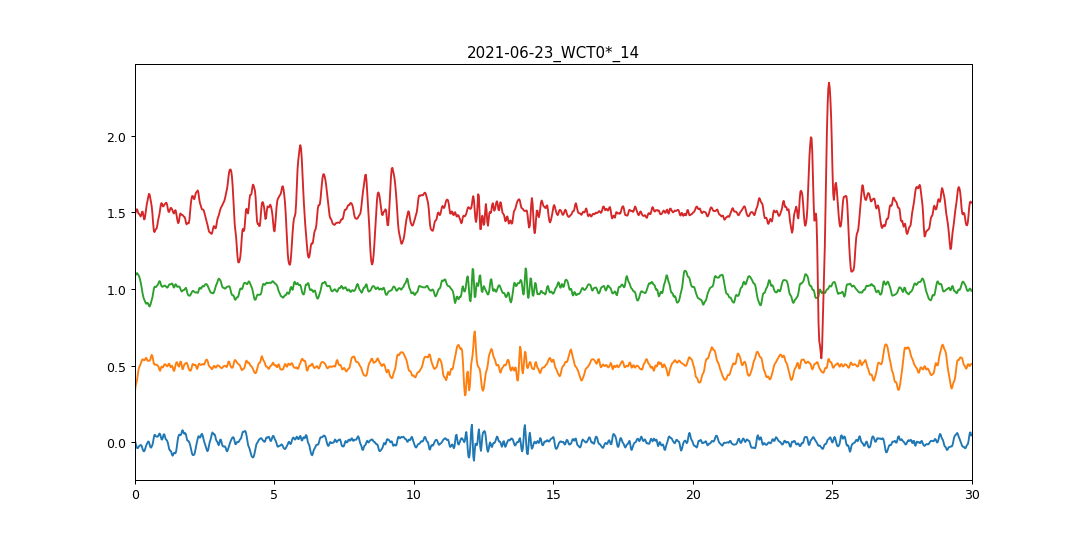

Text(0.5, 1.0, '2021-06-23_WCT0*_14')

In [8]:
%matplotlib notebook
label = '2021-06-23_WCT0*_14'
fig = plt.figure(figsize=(12,6))
signals = mcaap.extract_signals_from_dict(row_dict_WCT, label)
k = 0
for key in signals.keys():
    plt.plot(t_data, signals[key]+k)
    k += 0.5
plt.xlim([0,30]); plt.title(label)

---
Saving Each Database

In [10]:
%%time
data_dir = 'Databases/'
with open(data_dir+'MCB_dict.pkl', 'wb') as f:
    pickle.dump(row_dict_MCB, f) 
with open(data_dir+'WCT_dict.pkl', 'wb') as f:
    pickle.dump(row_dict_WCT, f) 

CPU times: user 90.7 ms, sys: 74 ms, total: 165 ms
Wall time: 254 ms


---
Miscellaneous code

In [ ]:
%%time
# Directory path to WCT trimmed data
file_pattern = summer_data_dir+'WCT_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
WCT_data = []; row_labels_WCT = []
for WCT_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(WCT_data_filepath)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter 5 - 10 Hz center cue and store 1 - 10 Hz signal
    st_center = st.copy() # 5 - 10 Hz center cue
    st_center.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_center.filter('bandpass', freqmin=5, freqmax=10)
    except:
        st_center = st_center.split()
        st_center.filter('bandpass', freqmin=5, freqmax=10)
        st_center.merge()
    # Filter 1 - 10 Hz store
    st_save = st.copy()
    st_save.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_save.filter('bandpass', freqmin=1, freqmax=10)
    except:
        st_save = st_save.split()
        st_save.filter('bandpass', freqmin=1, freqmax=10)
        st_save.merge()
    julian_day = WCT_data_filepath[-9:-6] # as string
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load onset times from WCT beam (will use same time for each station)
    signal_onset_time_filepath = summer_data_dir+'WCT_Detections/Beamform_Signal_Times_CWT/WCT_Beam/'+julian_day+'.npy'
    with open(signal_onset_time_filepath, 'rb') as f: # loading signal onset times
        WCT_times_tmp = np.load(f)[0]
    for sig_idx in range(len(WCT_times_tmp)):
        # Loop through each trace in stream
        for tr in st_center:
            # Too much impulsive noise at WCT01
            if tr.stats.station == 'WCT01':
                continue # move on from WCT01 - too many impulsive noise segments
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number - helps remove signals
            row_labels_WCT_tmp = f"{str(tr.stats.starttime).split('T')[0]}_{tr.stats.station}_{sig_idx+1}"
            row_labels_WCT.append(row_labels_WCT_tmp)
            #-----------------------------------------------------------------------------------------------------------------------#
            # Extract data from each trace using 30 second windows (+/- 15 seconds from beam onset time)
            t = np.arange(0, tr.stats.delta*tr.stats.npts, tr.stats.delta)
            # match same station in st_save
            tr_s_list = st_save.select(station=tr.stats.station)
            if len(tr_s_list) == 0: 
                continue
            tr_s = tr_s_list[0]
            # Window +/-15 s around beam onset (same cut for both)
            st_tmp = Stream().append(tr)
            st_tmp_s = Stream().append(tr_s)            
            #-----------------------------------------------------------------------------------------------------------------------#
            # Retrieve time windowed data
            t_data, data = cardinal.data_time_window(t, st_tmp, t_start=WCT_times_tmp[sig_idx]-15, t_end=WCT_times_tmp[sig_idx]+15)
            _, data_s = cardinal.data_time_window(t, st_tmp_s, t_start=WCT_times_tmp[sig_idx]-15, t_end=WCT_times_tmp[sig_idx]+15)
            #-----------------------------------------------------------------------------------------------------------------------#
            # Enforce target length (time axis is axis=1) - just in case
            fs = float(tr.stats.sampling_rate)
            target_length = int(30 * fs) # e.g., 40 s @ fs 
            data = pad_to_target_time(data, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            data_s = pad_to_target_time(data_s, target_length, axis=1, mode='noisy', noise_scale=0.1) 
            #-----------------------------------------------------------------------------------------------------------------------#
            # Compute shift from 5–10 Hz window, apply to 1–10 Hz window
            x = data[0, :].astype(np.float32)  # (T,)
            k_shift = center_by_env_peak(x) # time shift to center
            x_s = data_s[0, :].astype(np.float32)
            k_shift += int(round( (-k) * fs))
            x_s_centered = shift_extrapolate_time(x_s[None,:], k_shift, axis=1, mode='noisy', noise_scale=0.1)[0] 
            WCT_data.append(x_s_centered)
WCT_data = np.array(WCT_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_WCT = {label: WCT_data[idx] for idx, label in enumerate(row_labels_WCT)}
print(WCT_data.shape)

In [9]:
%%time
# Directory path to WCT trimmed data
file_pattern = summer_data_dir+'WCT_Detections/Data/*mseed'
# Loop through each day worth of signal onset times
WCT_data = []; row_labels_WCT = []
for WCT_data_filepath in glob.glob(file_pattern):
    # Read in data as unfiltered Obspy stream object
    st = read(WCT_data_filepath)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter
    st_filt = st.copy()
    st_filt.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_filt.filter('bandpass', freqmin=1, freqmax=10)
    except:
        st_filt = st_filt.split()
        st_filt.filter('bandpass', freqmin=1, freqmax=10)
        st_filt.merge()
    julian_day = WCT_data_filepath[-9:-6] # as string
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load onset times from WCT beam (will use same time for each station)
    signal_onset_time_filepath = summer_data_dir+'WCT_Detections/Beamform_Signal_Times_CWT/WCT_Beam/'+julian_day+'.npy'
    with open(signal_onset_time_filepath, 'rb') as f: # loading signal onset times
        WCT_times_tmp = np.load(f)[0]
    #-----------------------------------------------------------------------------------------------------------------------#
    # Fixing issues after manually checking signals
    if str(st[0].stats.starttime).split('T')[0] == '2021-06-09':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-06-10':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-06-11':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-07-06':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-09-07':
        continue
    #-----------------------------------------------------------------------------------------------------------------------#
    if str(st[0].stats.starttime).split('T')[0] == '2021-09-13':
        continue        
    #-----------------------------------------------------------------------------------------------------------------------#
    for sig_idx in range(len(WCT_times_tmp)):
        # Fixing signal timing issues
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-16':
            if sig_idx+1 == 2: 
                WCT_times_tmp[sig_idx] -= 5
            if sig_idx+1 == 13: 
                WCT_times_tmp[sig_idx] -= 3
            if sig_idx+1 == 14: 
                WCT_times_tmp[sig_idx] -= 3
            if sig_idx+1 == 15: 
                WCT_times_tmp[sig_idx] -= 5
            if sig_idx+1 == 16: 
                WCT_times_tmp[sig_idx] -= 4
            if sig_idx+1 == 18: 
                WCT_times_tmp[sig_idx] -= 4
            if sig_idx+1 == 19: 
                WCT_times_tmp[sig_idx] -= 3
            if sig_idx+1 == 23: 
                WCT_times_tmp[sig_idx] -= 3
            if sig_idx+1 == 24: 
                WCT_times_tmp[sig_idx] -= 5
        #-----------------------------------------------------------------------------------------------------------------------#    
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-19':
            if sig_idx+1 == 19: 
                WCT_times_tmp[sig_idx] -= 3.5
        #-----------------------------------------------------------------------------------------------------------------------#    
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-22':
            if (sig_idx+1==2) or (sig_idx+1==3) or (sig_idx+1==4): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-23':
            if (sig_idx+1==2) or (sig_idx+1==3) or (sig_idx+1==4) or (sig_idx+1==5) or (sig_idx+1==6) or (sig_idx+1==7) or (sig_idx+1==26) or (sig_idx+1==31) or (sig_idx+1==34) or (sig_idx+1==37) or (sig_idx+1==38): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-24':
            if (sig_idx+1==19) or (sig_idx+1==27): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-25':
            if (sig_idx+1==34): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-28':
            if (sig_idx+1==8)or(sig_idx+1==9)or(sig_idx+1==10)or(sig_idx+1==11)or(sig_idx+1==12)or(sig_idx+1==13)or(sig_idx+1==14)or(sig_idx+1==15)or(sig_idx+1==17)or(sig_idx+1==44)or(sig_idx+1==46)or(sig_idx+1==48)or(sig_idx+1==49)or(sig_idx+1==50)or(sig_idx+1==51): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-06-29':
            if sig_idx+1==26: 
                WCT_times_tmp[sig_idx] -= 2.5
            if sig_idx+1==27:
                WCT_times_tmp[sig_idx] -= 6
            if (sig_idx+1==39)or(sig_idx+1==40)or(sig_idx+1==41)or(sig_idx+1==42)or(sig_idx+1==43)or(sig_idx+1==44)or(sig_idx+1==45)or(sig_idx+1==46)or(sig_idx+1==47): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-01':
            if sig_idx+1==2: 
                WCT_times_tmp[sig_idx] -= 5
            if sig_idx+1==3: 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-12':
            if (sig_idx+1==43): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-13':
            if sig_idx+1==2:
                WCT_times_tmp[sig_idx] -= 5
            if (sig_idx+1==5)or(sig_idx+1==6)or(sig_idx+1==7)or(sig_idx+1==8)or(sig_idx+1==9)or(sig_idx+1==10)or(sig_idx+1==11)or(sig_idx+1==13)or(sig_idx+1==14)or(sig_idx+1==22)or(sig_idx+1==23): 
                WCT_times_tmp[sig_idx] -= 4
            if sig_idx+1==12: 
                WCT_times_tmp[sig_idx] -= 2
        #-----------------------------------------------------------------------------------------------------------------------#        
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-23':
            if sig_idx+1==11:
                continue
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-07-29':
            if sig_idx+1==2: 
                WCT_times_tmp[sig_idx] -= 5
            if (sig_idx+1==4)or(sig_idx+1==5)or(sig_idx+1==6)or(sig_idx+1==7)or(sig_idx+1==8): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-04':
            if sig_idx+1==2: 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-05':
            if (sig_idx+1==18)or(sig_idx+1==19)or(sig_idx+1==20)or(sig_idx+1==29)or(sig_idx+1==30)or(sig_idx+1==31)or(sig_idx+1==41)or(sig_idx+1==44)or(sig_idx+1==46)or(sig_idx+1==48)or(sig_idx+1==49)or(sig_idx+1==50): 
                WCT_times_tmp[sig_idx] -= 4
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-09':
            if (sig_idx+1==5)or(sig_idx+1==6): 
                WCT_times_tmp[sig_idx] -= 6
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-10':
            if (sig_idx+1==20): 
                continue
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-12':
            if (sig_idx+1==13): 
                WCT_times_tmp[sig_idx] -= 6
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-16':
            if (sig_idx+1==8):
                WCT_times_tmp[sig_idx] -= 2.5
            if (sig_idx+1==38)or(sig_idx+1==39)or(sig_idx+1==40)or(sig_idx+1==41)or(sig_idx+1==42)or(sig_idx+1==43)or(sig_idx+1==44)or(sig_idx+1==45)or(sig_idx+1==46)or(sig_idx+1==47)or(sig_idx+1==48)or(sig_idx+1==49)or(sig_idx+1==50)or(sig_idx+1==51): 
                WCT_times_tmp[sig_idx] -= 5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-23':
            if (sig_idx+1==12)or(sig_idx+1==35):
                WCT_times_tmp[sig_idx] -= 2.5
            if (sig_idx+1==13)or(sig_idx+1==14)or(sig_idx+1==15)or(sig_idx+1==16)or(sig_idx+1==17)or(sig_idx+1==18)or(sig_idx+1==19)or(sig_idx+1==20)or(sig_idx+1==21)or(sig_idx+1==22)or(sig_idx+1==34): 
                WCT_times_tmp[sig_idx] -= 5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-24':
            if (sig_idx+1==41)or(sig_idx+1==42)or(sig_idx+1==43)or(sig_idx+1==44): 
                WCT_times_tmp[sig_idx] -= 2.5
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-26':
            if (sig_idx+1==51)or(sig_idx+1==52): 
                WCT_times_tmp[sig_idx] -= 6
        #-----------------------------------------------------------------------------------------------------------------------#
        if str(st[0].stats.starttime).split('T')[0] == '2021-08-30':
            if sig_idx+1 != 1: 
                WCT_times_tmp[sig_idx] -= 3.5
        #-----------------------------------------------------------------------------------------------------------------------#
        # Loop through each trace in stream
        for tr in st_filt:
            # Extract data from each trace using 30 second windows (+/- 15 seconds from beam onset time)
            t = np.arange(0, tr.stats.delta*tr.stats.npts, tr.stats.delta)
            st_tmp = Stream().append(tr)
            if tr.stats.station == 'WCT01':
                continue # move on from WCT01 - too many impulsive noise segments
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-14':
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1 == 22) or (sig_idx+1==23): 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-15':
                if tr.stats.station == 'WCT07':
                    if sig_idx+1 == 9: 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-17':
                if tr.stats.station == 'WCT07':
                    if sig_idx+1 == 2: 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-18':
                if tr.stats.station == 'WCT02':
                    if sig_idx+1 == 43: 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-19':
                if tr.stats.station == 'WCT02':
                    if sig_idx+1 == 25: 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-22':
                if tr.stats.station == 'WCT04': 
                    if (sig_idx+1==34) or (sig_idx+1==45): 
                        continue
                if tr.stats.station == 'WCT05': 
                    if (sig_idx+1==7) or (sig_idx+1==32) or (sig_idx+1==45): 
                        continue
                if tr.stats.station == 'WCT07': 
                    if (sig_idx+1==19) or (sig_idx+1==28): 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-24':
                if tr.stats.station == 'WCT02': 
                    if (sig_idx+1==29) or (sig_idx==30) or (sig_idx==37) or (sig_idx==52): 
                        continue
                if tr.stats.station == 'WCT04': 
                    if (sig_idx+1==18): 
                        continue
                if tr.stats.station == 'WCT05': 
                    if (sig_idx+1==18): 
                        continue
                if tr.stats.station == 'WCT07': 
                    if (sig_idx+1==18) or (sig_idx+1==29): 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-25':
                if tr.stats.station == 'WCT02': 
                    if (sig_idx+1==5): 
                        continue
                if tr.stats.station == 'WCT05': 
                    if (sig_idx+1==29): 
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-06-29':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==2) or (sig_idx+1==28):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-14':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==10) or (sig_idx+1==26):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-22':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==40):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-23':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==9) or (sig_idx+1==10) or (sig_idx+1==12):
                        continue
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==8):
                        continue
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==6):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-07-28':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==23):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-05':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==25):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-10':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==11)or(sig_idx+1==17):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            if str(st[0].stats.starttime).split('T')[0] == '2021-08-20':
                if tr.stats.station == 'WCT02':
                    if (sig_idx+1==3)or(sig_idx+1==4)or(sig_idx+1==7):
                        continue
                if tr.stats.station == 'WCT04':
                    if (sig_idx+1==1)or(sig_idx+1==2)or(sig_idx+1==4)or(sig_idx+1==6)or(sig_idx+1==8)or(sig_idx+1==10):
                        continue
                if tr.stats.station == 'WCT05':
                    if (sig_idx+1==12):
                        continue
                if tr.stats.station == 'WCT07':
                    if (sig_idx+1==39):
                        continue
            #-----------------------------------------------------------------------------------------------------------------------#
            # Slightly changing the centering to capture more of the coda
            t_data, data = cardinal.data_time_window(t, st_tmp, t_start=WCT_times_tmp[sig_idx]-10, t_end=WCT_times_tmp[sig_idx]+20)
            #-----------------------------------------------------------------------------------------------------------------------#
            # Enforce target length (time axis is axis=1) - just in case
            fs = float(tr.stats.sampling_rate)
            target_length = int(30 * fs) # e.g., 40 s @ fs 
            data = pad_to_target_time(data, target_length, axis=1, mode='noisy', noise_scale=0.1) 
#             # Desired length
#             target_length = 40 * 30 # sampling rate and time window length
#             if data.shape[1] != target_length:
#                 # Calculate padding required on each side
#                 pad_width = target_length - data.shape[1]
#                 # Pad the array on both sides to reach target length
#                 data = np.pad(data, (0, pad_width), mode='constant')
            WCT_data.append(data[0,:])
            #-----------------------------------------------------------------------------------------------------------------------#
            # Dictionary mapping row indices to day, sensor, and signal number
            row_labels_WCT.append(str(tr.stats.starttime).split('T')[0] + '_'+tr.stats.station+'_'+str(sig_idx+1))
WCT_data = np.array(WCT_data)
#-----------------------------------------------------------------------------------------------------------------------#
# Create dictionary (keys are event date, sensor, and signal number - values are infrasound sensor data)
row_dict_WCT = {label: WCT_data[idx] for idx, label in enumerate(row_labels_WCT)}
print(WCT_data.shape)

(12527, 1200)
CPU times: user 1min 38s, sys: 2.89 s, total: 1min 41s
Wall time: 1min 43s


<IPython.core.display.Javascript object>


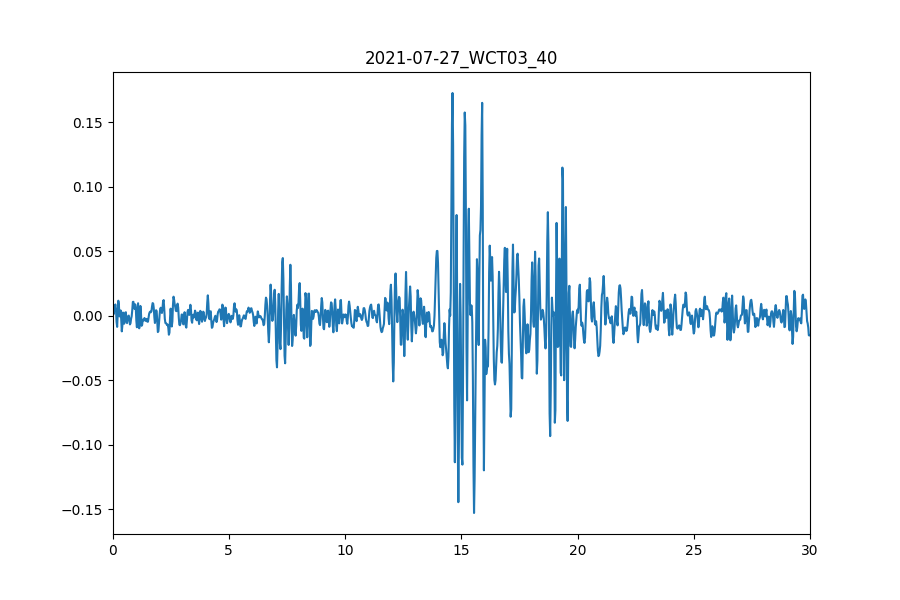

Text(0.5, 1.0, '2021-07-27_WCT03_40')

In [10]:
%matplotlib notebook
# Generate a random integer between 0 and total number of signals at EOCR
rand_int = random.randint(0, WCT_data.shape[0])
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting randomly indexed signal
fig = plt.figure(figsize=(9,6))
data_label, data_tmp = mcaap.extract_signals_from_dict(row_dict_WCT, rand_int)
plt.plot(t_data, data_tmp)
plt.xlim([0,30]); plt.title(data_label)

<IPython.core.display.Javascript object>


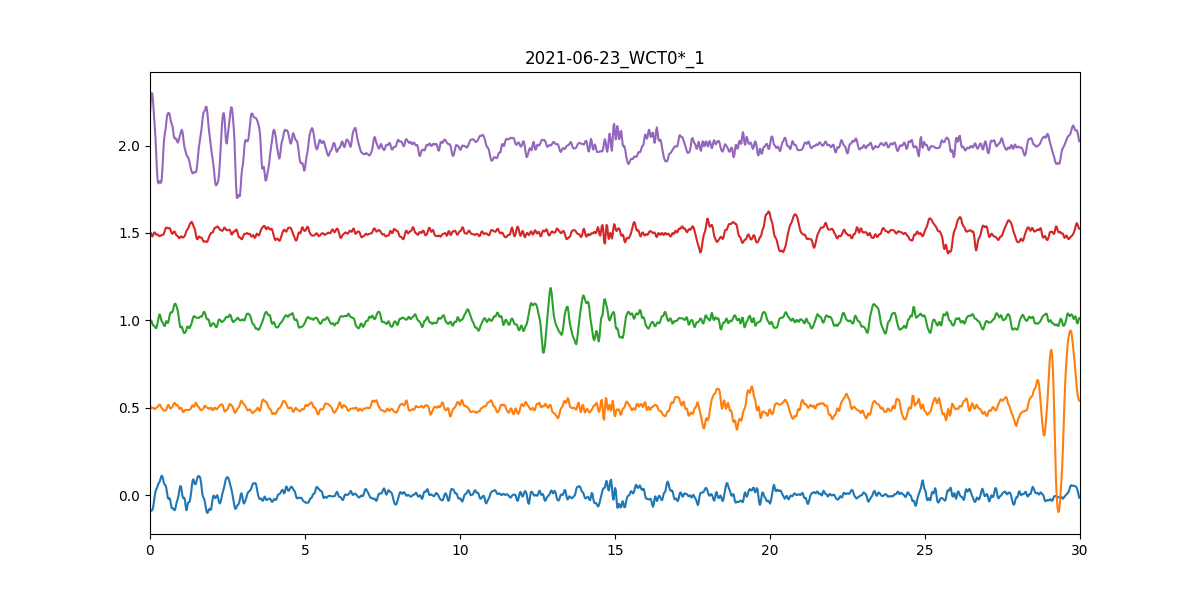

Text(0.5, 1.0, '2021-06-23_WCT0*_1')

In [11]:
%matplotlib notebook
label = '2021-06-23_WCT0*_1'
fig = plt.figure(figsize=(12,6))
signals = mcaap.extract_signals_from_dict(row_dict_WCT, label)
k = 0
for key in signals.keys():
    plt.plot(t_data, signals[key]+k)
    k += 0.5
plt.xlim([0,30]); plt.title(label)